In [137]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.svm import SVR
from scipy.stats import uniform, randint, pearsonr
from sklearn.base import clone

%matplotlib inline

##### Reading data

In [2]:
data = pd.read_csv('concrete.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
cement          1030 non-null float64
slag            1030 non-null float64
ash             1030 non-null float64
water           1030 non-null float64
superplastic    1030 non-null float64
coarseagg       1030 non-null float64
fineagg         1030 non-null float64
age             1030 non-null int64
strength        1030 non-null float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


- All variables are of numeric type

In [4]:
data.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


##### Missing Values

In [5]:
data.isna().sum()

cement          0
slag            0
ash             0
water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
strength        0
dtype: int64

##### Duplicate rows

In [6]:
data.duplicated().sum()

25

# Univariate Analysis

##### Independent Variables
- cement 
- slag	
- ash
- water	
- superplastic	
- coarseagg
- fineagg	
- age
---
###### Dependent Variable
- strength

In [7]:
data_mdl = data.copy()

In [8]:
data_mdl.describe().T

,count,mean,std,min,25%,50%,75%,max
cement,1030.0,281.167864,104.506364,102.00,192.375,272.900,350.000,540.0
slag,1030.0,73.895825,86.279342,0.00,0.000,22.000,142.950,359.4
ash,1030.0,54.188350,63.997004,0.00,0.000,0.000,118.300,200.1
water,1030.0,181.567282,21.354219,121.80,164.900,185.000,192.000,247.0
superplastic,1030.0,6.204660,5.973841,0.00,0.000,6.400,10.200,32.2
coarseagg,1030.0,972.918932,77.753954,801.00,932.000,968.000,1029.400,1145.0
fineagg,1030.0,773.580485,80.175980,594.00,730.950,779.500,824.000,992.6
age,1030.0,45.662136,63.169912,1.00,7.000,28.000,56.000,365.0
strength,1030.0,35.817961,16.705742,2.33,23.710,34.445,46.135,82.6


##### Skewness

In [9]:
data_mdl.skew()

cement          0.509481
slag            0.800717
ash             0.537354
water           0.074628
superplastic    0.907203
coarseagg      -0.040220
fineagg        -0.253010
age             3.269177
strength        0.416977
dtype: float64

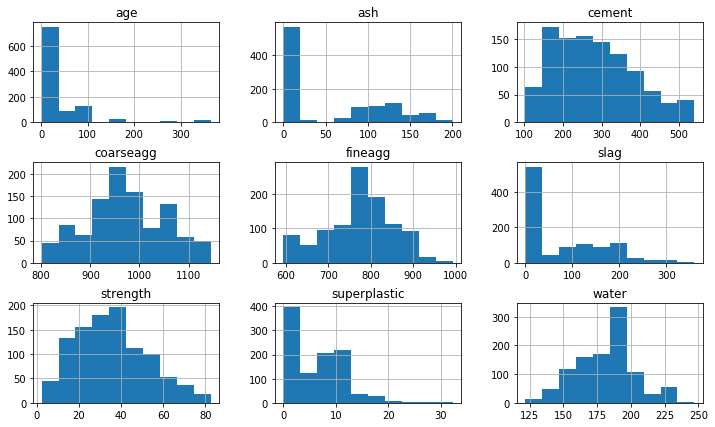

In [10]:
data_mdl.hist(figsize=(12, 7))
plt.subplots_adjust(hspace=0.4);

In [11]:
data_mdl['age'].quantile(0.93)

100.0

- Large values of 'age' (above 100) are infrequent. 90% of all values are below 100. 
- Numerous outliers present in 'age'.
- 'cement' is a bit right skewed.
- 'coarseagg' is roughly normal distributed.
- distribution of 'fineagg' is roughly normal.
- distribution of 'water' is roughly normal.
- Frequency decreases with an increase in 'superplastic'.
- 'strength' which is target variable is bit right skewed-0.4

## Checking Outliers

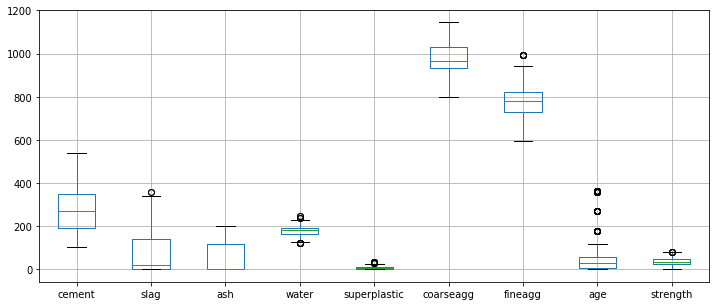

In [12]:
data_mdl.boxplot(figsize=(12, 5));

##### Identifying outliers based on IQR.
##### Replacing outliers in 'age' with mean while others with 'median'.

In [13]:
for c in data_mdl.columns:
    Q1 = data_mdl[c].quantile(.25)
    Q3 = data_mdl[c].quantile(.75)
    IQR = Q3 - Q1
    out = (data_mdl[c] > Q3+(1.5*IQR)) | (data_mdl[c] < Q1-(1.5*IQR))
    if c=='age':
        data_mdl.loc[out, c] = data_mdl[c].mean()
        break
    data_mdl.loc[out, c] = data_mdl[c].median()

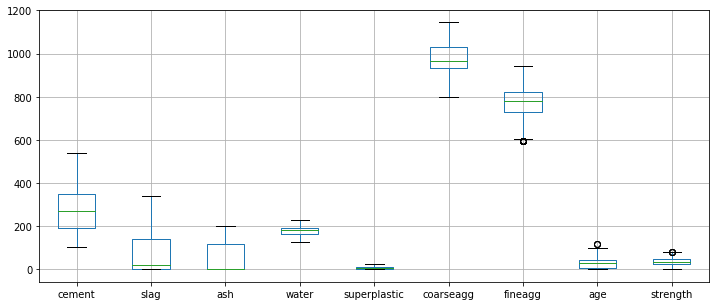

In [14]:
data_mdl.boxplot(figsize=(12, 5));

fine

# Bivariate Analysis

#### Correlation Matrix

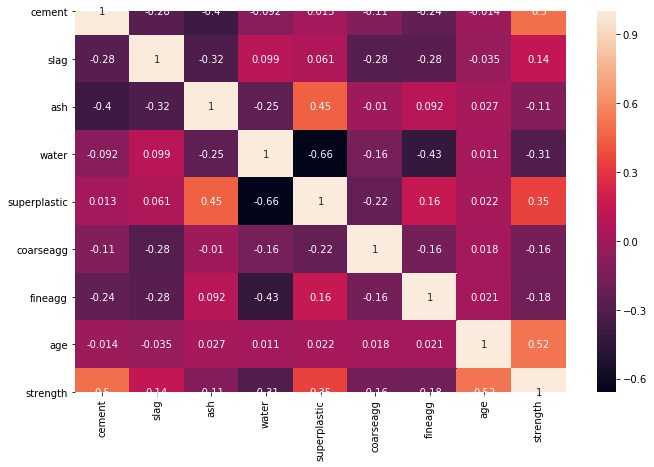

In [15]:
plt.figure(figsize=(11, 7))
sns.heatmap(data_mdl.corr(), annot=True);

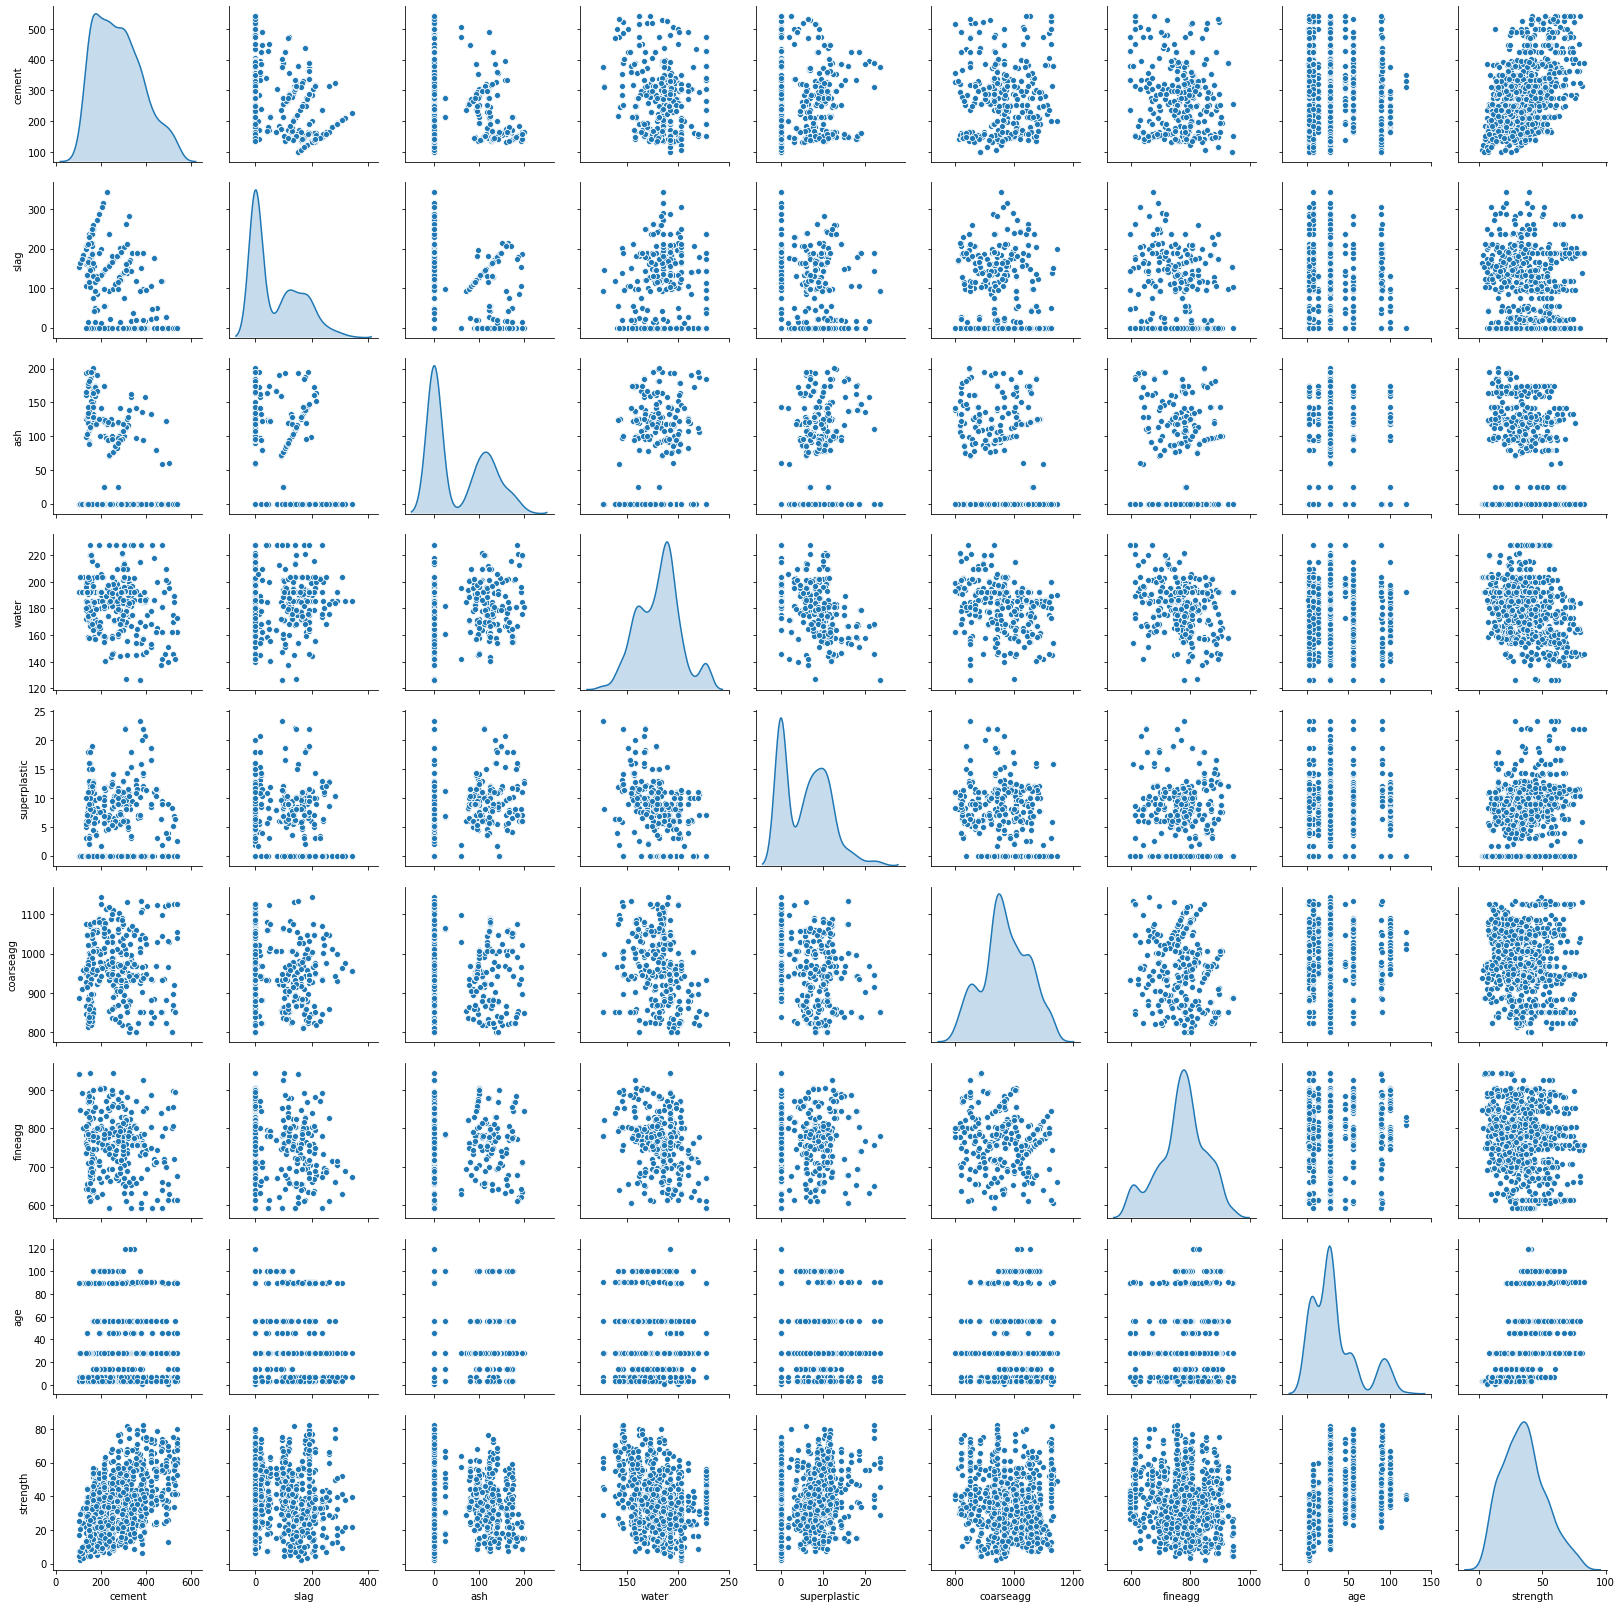

In [16]:
sns.pairplot(data_mdl, diag_kind='kde');

##### with strength

- 'cement' has a positive correlation with 'strength'
- 'age' appears to have positive correlation with 'strength'
- 'coarseagg' and 'fineagg' doesn't seem to have any relationship with 'strength'. Their scatterplot with 'strength' is almost cloud like.

- 'water' and 'superplatic' have a negative correlation
- 'water' and 'fineagg' have a bit of negative correlation
- Relationship between all other variables are not significant

- Looking at relationship between 'cement' and 'strength', perhaps more sophisticated algorithms like SVM will do a better job than Linear Regression

##### Data appears to be a mix of gaussian
- 'slag' has two gaussians
- 'ash' has two gaussians
- 'superplatic' has two gaussians
- age has multiple gaussians

## Clustering data using K-Means for further analysis

##### KMeans requires all variables to be on similar scale

In [17]:
data_mdl_z = pd.DataFrame(StandardScaler().fit_transform(data_mdl), columns=data_mdl.columns)

In [18]:
ks = [k for k in range(2, 9)]
inertias = []
for k in ks:
    km = KMeans(n_clusters=k, n_jobs=-1, random_state=123)
    km.fit(data_mdl_z)
    inertias.append(km.inertia_)

##### Elbow curve

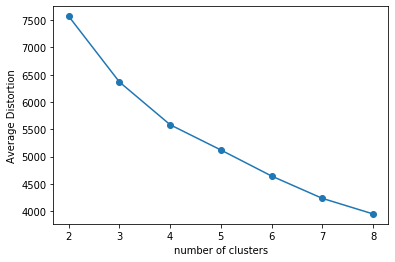

In [19]:
plt.xlabel('number of clusters')
plt.ylabel('Average Distortion')
plt.plot(ks, inertias, 'o-');

##### setting k=4

In [20]:
km = KMeans(n_clusters=4, n_jobs=-1, random_state=123)
km.fit(data_mdl_z)
data_mdl_z['group'] = km.labels_

In [21]:
data_mdl_z.head(3)

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength,group
0,-1.339017,1.625902,-0.847144,1.060879,-1.091166,-0.014398,-0.305676,-0.188562,-0.355018,2
1,-1.074790,-0.363717,1.096078,-1.134020,0.881615,1.388141,0.300692,-0.689672,-0.737108,3
2,-0.298384,-0.858192,0.648965,0.279067,-0.086509,-0.206121,1.126981,-0.188562,-0.395144,3


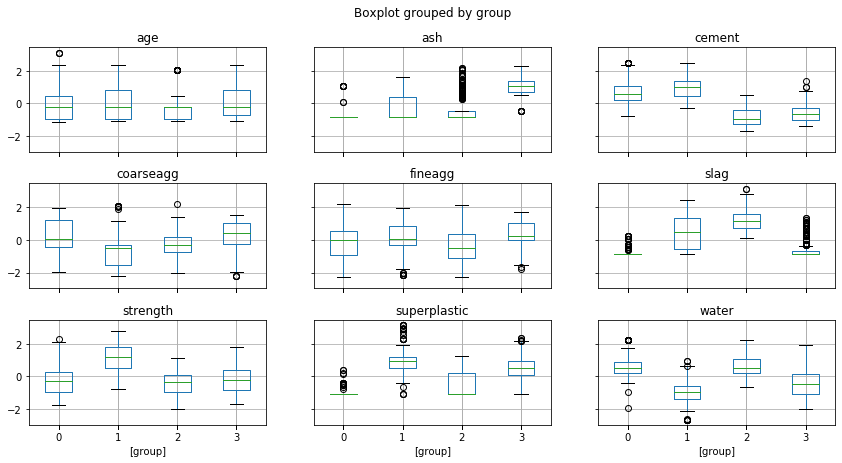

In [22]:
data_mdl_z.boxplot(by='group', figsize=(14, 7))
plt.subplots_adjust(hspace=.3)

##### Although there exist clusters in the data, there are significant overlaps between the groups in the above figure. So there aren't any distinct characteristics between clusters. Thus it will not be beneficial to build separate models for each cluster.

C:\Users\utkar\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\utkar\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


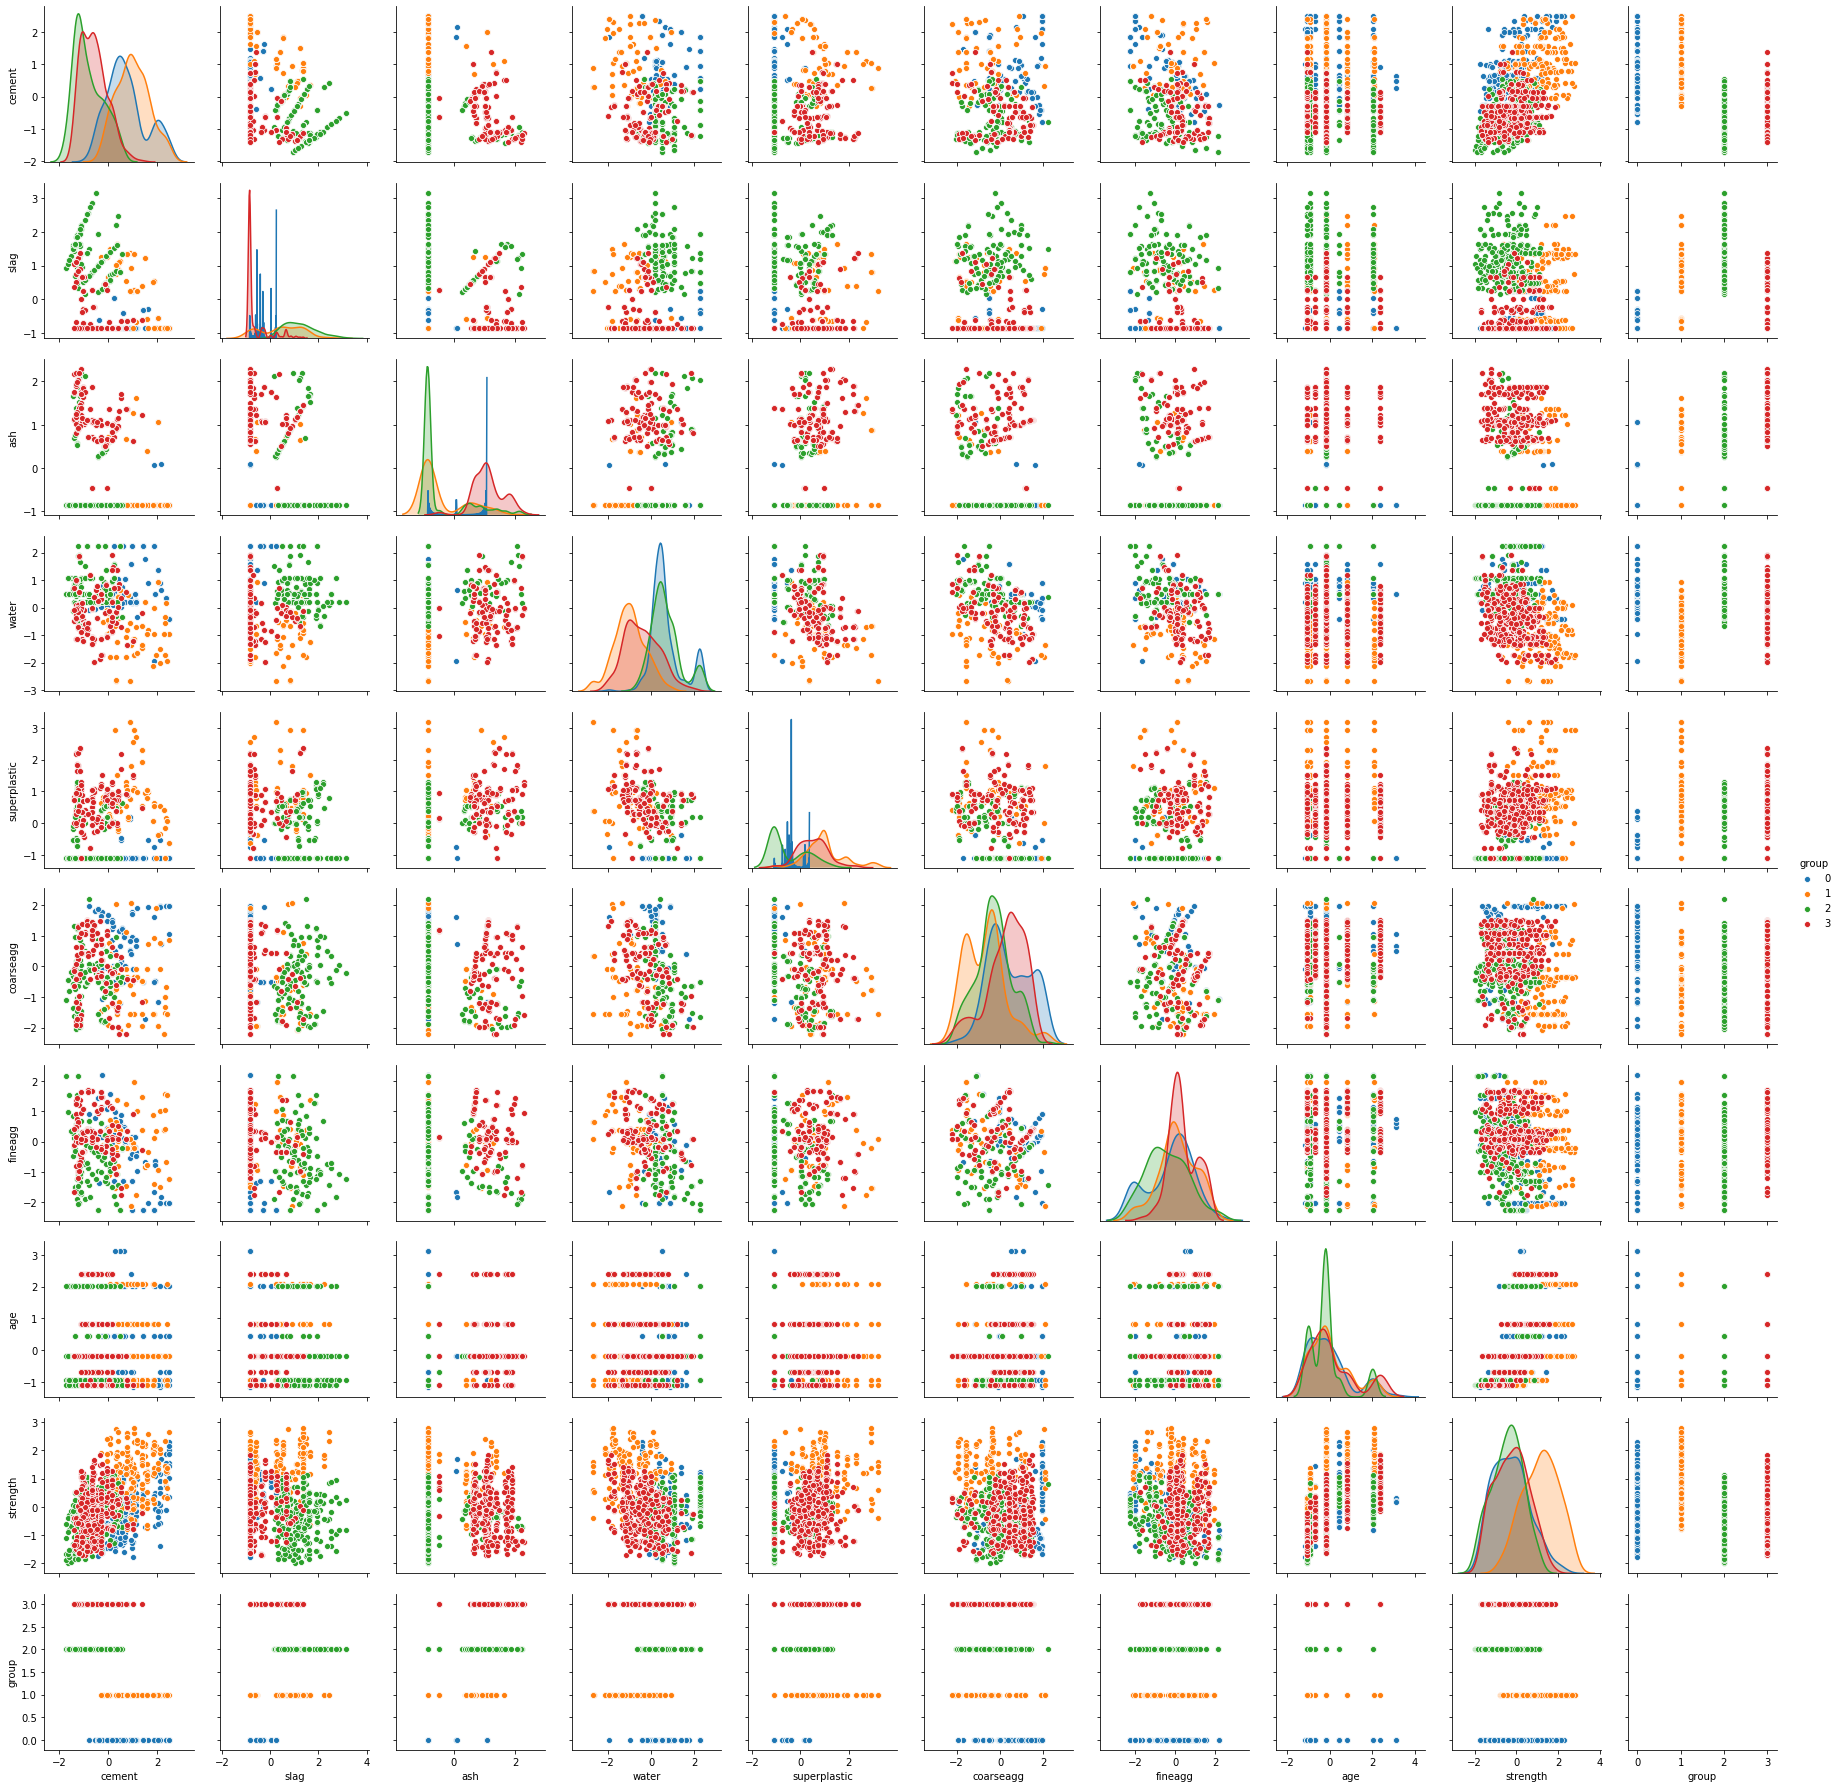

In [23]:
sns.pairplot(data_mdl_z, hue='group');

### Preparing data for modelling

In [24]:
X = data_mdl.iloc[:, :-1]
y = data_mdl.iloc[:, -1]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=123)

##### Standardization

In [26]:
scaler = StandardScaler()
X_train_scl = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scl = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

### Feature Importance

- using Lasso

### Lasso

#####  Lasso requires all features to be on comparable scale. So we will use standardized data.

In [27]:
ls = Lasso(alpha=1, random_state=123)
ls.fit(X_train_scl, y_train)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=123, selection='cyclic',
      tol=0.0001, warm_start=False)

In [28]:
print('Train: ', ls.score(X_train_scl, y_train))
print('Test:  ', ls.score(X_test_scl, y_test))

Train:  0.7060895283293664
Test:   0.7000856645517479


#### Coefficient of a variable represent its importance.

In [29]:
sp = ' '
for i in range(len(X.columns)):
    col = X.columns[i]
    print(f'Coef. of {col}{sp*(14-len(col))}:  ', ls.coef_[i])

Coef. of cement        :   8.027689427535062
Coef. of slag          :   3.45672982172934
Coef. of ash           :   0.0
Coef. of water         :   -2.1944268516441037
Coef. of superplastic  :   2.6870865345815105
Coef. of coarseagg     :   -0.0
Coef. of fineagg       :   -0.552751238772393
Coef. of age           :   8.044637242107118


- As can be seen, 'cement' and 'age' are the variables which have the most predictive strength.
- followed by 'slag', 'superplastic', 'water', 'fineagg'
- 'ash' and 'coarseagg' have coefficient value 0.
- 'ash', 'coarseagg' and 'fineagg' do not add much value

## Helper Functions

In [30]:
def run_bootstraping(data, model, n_samples):
    '''
       Generate samples by Bootsraping technique and calculates score on each sample.
       data: ndarray
       n_sample: number of samples to generate
       Returns: array of all scores
    '''
    scores = []
    for i in range(n_samples):
        tr_idx = np.random.choice(np.arange(data.shape[0]), data.shape[0])
        train = data[tr_idx, :]
        test = np.delete(data, tr_idx, 0)
        xtr, xte, ytr, yte = train[:, :-1], test[:, :-1], train[:, -1], test[:, -1] 
        scaler = StandardScaler()
        xtr = scaler.fit_transform(xtr)
        xte = scaler.transform(xte)
        model.fit(xtr, ytr)
        scores.append(model.score(xte, yte))
    return scores

In [31]:
def build_confidence_interval(conf_level, scores):
    ''' 
        Plot a hitogram of all scores generated by bootstraping technique.
        conf_level: Confidence interval, 0-100
        scores: array 
    '''
    alpha = 1-(conf_level/100)
    lower = np.quantile(scores, alpha/2)
    upper = np.quantile(scores, 1-(alpha/2))
    plt.xlabel('score')
    plt.hist(scores)
    plt.show()
    print(f'{conf_level}% Confidence Interval: ({lower}, {upper})')

In [32]:
comp_algo = pd.DataFrame(columns=['Algorithm', 'Train Score', 'Test Score'])
def add_algo(name, tr_sc, te_sc):
    '''
        Keeps track of each algorithm used and its corresponding accuracy on test data.
        name: string, Algorithm used
        score: Accuracy
    '''
    global comp_algo
    if comp_algo['Algorithm'].isin([name]).any():
        return
    df = pd.DataFrame({'Algorithm':[name], 'Train Score':[tr_sc], 'Test Score':te_sc})
    comp_algo = comp_algo.append(df)

# Building Model

- SVM
- Linear Regression
- Lasso
#### Ensemble
- Random Forest
- Bagging with SVM (Ensemble)
- Grading Boosting

## Support Vector Machine

##### SVM requires all features to be standardized

In [33]:
svr_rbf = SVR(kernel='rbf') 
svr_rbf.fit(X_train_scl, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [34]:
print('Train: ', svr_rbf.score(X_train_scl, y_train))
print('Test:  ', svr_rbf.score(X_test_scl, y_test))

Train:  0.724959717495264
Test:   0.7249067620412049


### Hyperparameter Optimization

##### Confining search space of parameter 'C' below 7 to prevent overfitting.

In [35]:
params_svr_rbf = {'C': uniform(0, 4),
                     'epsilon': uniform(0, 2), 
                     'gamma': uniform(0, 2)}

In [36]:
random_cv_svr_rbf = RandomizedSearchCV(svr_rbf, params_svr_rbf, n_iter=600, cv=5, n_jobs=-1, random_state=123)
random_cv_svr_rbf.fit(X_train_scl, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=600, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020E1390DB88>,
                                        'epsilon': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020E133A8D88>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020E13ADE848>},
                   pre_dispatch='2*n_jobs', random_state=123, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [37]:
svr_rbf = SVR(**random_cv_svr_rbf.best_params_)
svr_rbf.fit(X_train_scl, y_train)
y_pred_svr_rbf = svr_rbf.predict(X_test_scl)

### Accuracy

In [38]:
tr, te = svr_rbf.score(X_train_scl, y_train), svr_rbf.score(X_test_scl, y_test)

In [39]:
print('Train: ', tr)
print('Test:  ', te)

Train:  0.8582850106315371
Test:   0.8426993037105236


In [40]:
add_algo('SVM', tr, te)

### Actual vs Prediction

C:\Users\utkar\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


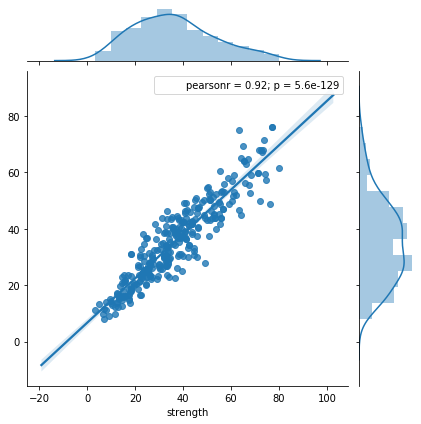

In [41]:

sns.jointplot(y_test, y_pred_svr_rbf, data_mdl, kind='reg').annotate(pearsonr);

### Building Confidence interval using Bootstraping

In [42]:
scores_svr_rbf = run_bootstraping(data_mdl.values, SVR(**random_cv_svr_rbf.best_params_), 1000)

##### Confidence Interval with 95% confidence level.

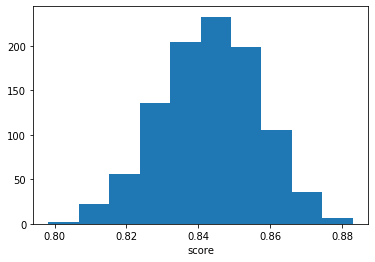

95% Confidence Interval: (0.8157562603633048, 0.8678516259616595)


In [43]:
build_confidence_interval(95, scores_svr_rbf)

## Linear Regression

In [44]:
lr = LinearRegression(n_jobs=-1)
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [45]:
tr, te = lr.score(X_train, y_train), lr.score(X_test, y_test)
print('Train: ', tr)
print('Test : ', te)

Train:  0.7355062844513256
Test :  0.748330921033173


In [46]:
add_algo('Linear Regression', tr, te)

## Lasso

In [47]:
ls = Lasso(alpha=1, random_state=123)
ls.fit(X_train_scl, y_train)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=123, selection='cyclic',
      tol=0.0001, warm_start=False)

In [48]:
print('Train: ', ls.score(X_train_scl, y_train))
print('Test : ', ls.score(X_test_scl, y_test))

Train:  0.7060895283293664
Test :  0.7000856645517479


### Hyperparameter Optimization

In [49]:
params_ls = {'alpha':uniform(0, 1)}

In [50]:
random_cv_ls = RandomizedSearchCV(ls, params_ls, n_iter=200, cv=5, n_jobs=-1, random_state=123)
random_cv_ls.fit(X_train_scl, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Lasso(alpha=1, copy_X=True, fit_intercept=True,
                                   max_iter=1000, normalize=False,
                                   positive=False, precompute=False,
                                   random_state=123, selection='cyclic',
                                   tol=0.0001, warm_start=False),
                   iid='deprecated', n_iter=200, n_jobs=-1,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020E12EEC3C8>},
                   pre_dispatch='2*n_jobs', random_state=123, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [51]:
ls = Lasso(**random_cv_ls.best_params_)
ls.fit(X_train_scl, y_train)
y_pred_ls = ls.predict(X_test_scl)

### Accuracy

In [52]:
tr, te = ls.score(X_train_scl, y_train), ls.score(X_test_scl, y_test)
print('Train: ', tr)
print('Test : ', te)

Train:  0.7355059752322136
Test :  0.7482536410367969


In [53]:
add_algo('Lasso', tr, te)

### Actual vs Prediction

C:\Users\utkar\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


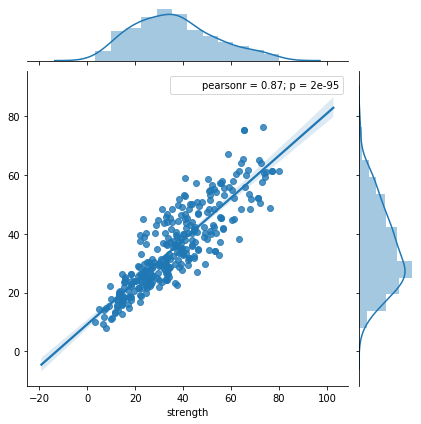

In [54]:
sns.jointplot(y_test, y_pred_ls, data_mdl, kind='reg').annotate(pearsonr);

### Building Confidence interval using Bootstraping

In [55]:
scores_ls = run_bootstraping(data_mdl.values, Lasso(**random_cv_ls.best_params_), 1000)

##### Confidence Interval with 95% confidence level.

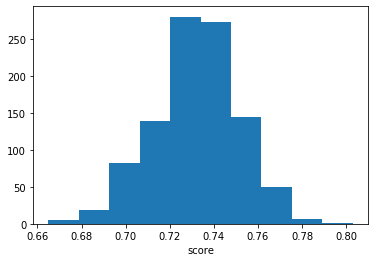

95% Confidence Interval: (0.6928215515471938, 0.7677565023647671)


In [56]:
build_confidence_interval(95, scores_ls)

## Random Forest

In [57]:
rf = RandomForestRegressor(random_state=123)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)

In [58]:
print('Train: ', rf.score(X_train, y_train))
print('Test : ', rf.score(X_test, y_test))

Train:  0.9832646972407391
Test :  0.9034696294212389


overfitting!

### Hyperparameter Optimization

In [59]:
params_rf = {'max_depth': randint(1, 4),
             'max_features': randint(1, 6),
             'min_samples_leaf': randint(1, 8),
             'min_samples_split': randint(2, 8),
             'n_estimators': [100]}

In [101]:
random_cv_rf = RandomizedSearchCV(rf, params_rf, n_iter=10, cv=5, n_jobs=-1, random_state=123)
random_cv_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [104]:
rf = RandomForestRegressor(**random_cv_rf.best_params_)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features=5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=7, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

### Accuracy

In [105]:
tr, te = rf.score(X_train, y_train), rf.score(X_test, y_test)
print('Train: ', tr)
print('Test : ', te)

Train:  0.7296561495292707
Test :  0.7039407199780054


In [133]:
add_algo('Random Forest', tr, te)

## Bagging with SVM

##### Bagging works by aggregrating many base estimators.
##### It is a way to reduce variance of the base estimator (overfitting).
##### So, let's use a overfited SVM as the base estimator.

##### Since parameter 'C' controls the overfitting. Let's set 'C' value to a very high number to get a overfitting model.

In [63]:
reg = SVR(kernel='rbf', C=100000) 
reg.fit(X_train_scl, y_train)

SVR(C=100000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [64]:
print('Train: ', reg.score(X_train_scl, y_train))
print('Test : ', reg.score(X_test_scl, y_test))

Train:  0.9911216214773012
Test :  0.04490488671550086


In [65]:
# Bagging
bg_svr = BaggingRegressor(reg, n_estimators=400, max_samples=0.1, n_jobs=-1, bootstrap=False)
bg_svr.fit(X_train_scl, y_train)
y_pred_bg_svr = bg_svr.predict(X_test_scl)

### Accuracy

In [66]:
tr, te = bg_svr.score(X_train_scl, y_train), bg_svr.score(X_test_scl, y_test)
print('Train: ', tr)
print('Test : ', te)

Train:  0.8743936796487533
Test :  0.8575187809428652


In [134]:
add_algo('Bagging SVM', tr, te)

### Actual vs Prediction

C:\Users\utkar\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


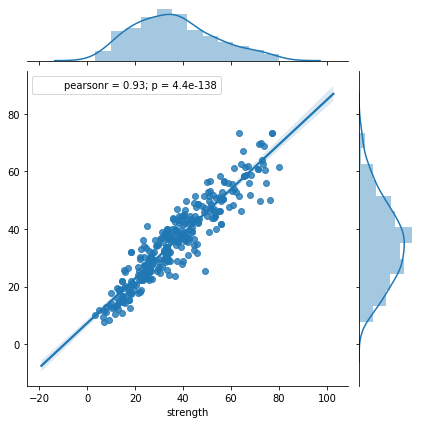

In [68]:
sns.jointplot(y_test, y_pred_bg_svr, data_mdl, kind='reg').annotate(pearsonr);

### Building Confidence interval using Bootstraping

In [69]:
scores_bg_svr = run_bootstraping(data_mdl.values, clone(bg_svr), 1000)

##### Confidence Interval with 95% confidence level.

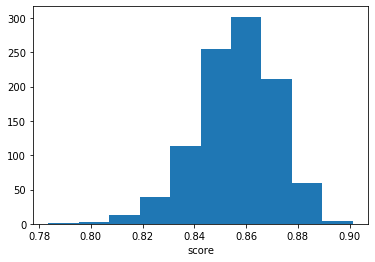

95% Confidence Interval: (0.8227126735253522, 0.8828352961602235)


In [70]:
build_confidence_interval(95, scores_bg_svr)

## Gradient Boosting

In [95]:
gr_boost = GradientBoostingRegressor(max_depth=2, subsample=0.1)
gr_boost.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=0.1, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [96]:
print('Train: ', gr_boost.score(X_train, y_train))
print('Test : ', gr_boost.score(X_test, y_test))
y_pred_gr_boost = gr_boost.predict(X_test)

Train:  0.8970517596872993
Test :  0.8802657014621618


### Actual vs Prediction

C:\Users\utkar\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


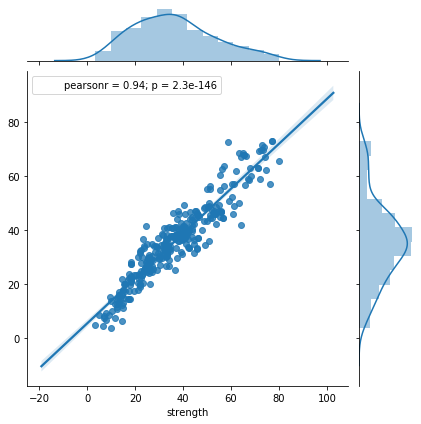

In [97]:
sns.jointplot(y_test, y_pred_gr_boost, data_mdl, kind='reg').annotate(pearsonr);

### Building Confidence interval using Bootstraping

In [98]:
scores_gr_boost = run_bootstraping(data_mdl.values, clone(gr_boost), 1000)

##### Confidence Interval with 95% confidence level.

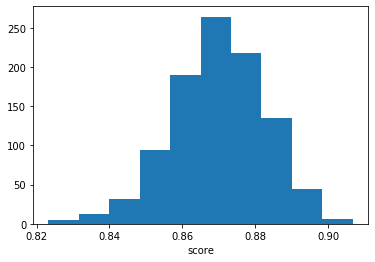

95% Confidence Interval: (0.8437618442410852, 0.8927335090116296)


In [99]:
build_confidence_interval(95, scores_gr_boost)

## Comparing all algorithms

In [136]:
comp_algo

,Algorithm,Train Score,Test Score
0,SVM,0.858285,0.842699
1,Linear Regression,0.735506,0.748331
2,Lasso,0.735506,0.748254
3,Bagging SVM,0.874394,0.857519
4,Gradient Boosting,0.895176,0.880606
0,Random Forest,0.729656,0.703941


- Gradient Boosting performs the best, followed by Bagging SVM